# **Irene Dovichi** 
## Midterm 2 - Assignment 3
Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1. Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2. Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3. Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import idx2numpy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.metrics import structural_similarity

## Dataset Loading

In [2]:
dataset_folder = 'mnist_db/'

# Load train and test images
train_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-images-idx3-ubyte'))
test_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-images-idx3-ubyte'))

# Load train and test labels
train_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-labels-idx1-ubyte'))
test_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-labels-idx1-ubyte'))

Image shape: (28, 28)
Pixel value range: 0 - 255
Label: 5


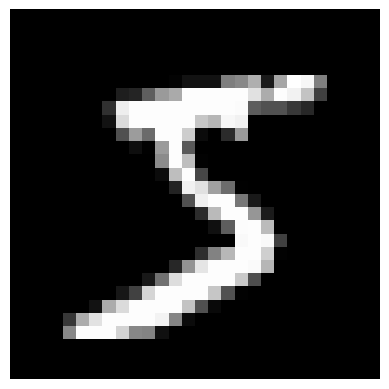

In [3]:
# Print the first image in the train set
first_image = train_images[0]
first_label = train_labels[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

# Print the label of the image
print("Label:", first_label)

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


### Data Preprocessing

First, we move from a range of 0 - 255 to a range of 0 - 1 to uniform the data; then, we binarize using 0.5 as threshold, and finally we flatten the images so that we will work with 1D arrays.

In [4]:
# Normalize pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Binarize the images
threshold = 0.5
train_images_b = np.where(train_images > threshold, 1, 0)
test_images_b = np.where(test_images > threshold, 1, 0)

# Reshape to 1D array
train_images_b = train_images_b.reshape(-1, 28*28)
test_images_b = test_images_b.reshape(-1, 28*28)

Image shape: (784,)
Pixel value range: 0 - 1


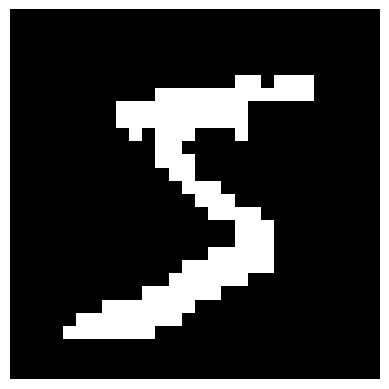

In [5]:
# See the change in the first image of the train set
first_image = train_images_b[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

## RBM Implementation 

I implemented the class `RBM` from scratch in the next cell; some relevant choices are as follows:
- I initialized the weights with a Gaussian distribution of mean 0 and standard deviation 0.01
- I initialized the biases of visible units considering the proportion of training data in which they were on, i.e., for each unit $i = 1, \dots, n_{visible}$ the initial weight was: $$log\bigl(\frac{p_i + \varepsilon}{1 - p_i + \varepsilon}\bigr)$$ where $p_i$ is the average number of train images that have pixel $i$ turned on, and $\varepsilon=$ 1e-5 was added to avoid problems in case of a zero denominator
- I initialized the biases of hidden units to zero
- I implemented a `train()` method which is CD-1 in the mini-batch version, monitoring the squared error between the data and the reconstructions
- When computing the dream part, I sampled the binary hidden states based on $P(h|v)$ (I called this distribution `hidden_prob` in the code); however, I took states directly as probabilities when dealing with reconstructions (in the code: `recon_states`=`recon_prob`)
- The method `encoding()` takes input data and computes how likely each hidden unit is to be activated given that input data; therefore, the probabilities returned can be interpreted as the encoding of the input data into the hidden layer representation
- The method `reconstruct()` applies an extra step to the `encoding()` method: it calculates the reconstruction probabilities of the visible units using `hidden_prob` directly as `hidden_states` in the formula (unlike what was done in the training, in which a binary sampling was done); therefore, the probabilities returned can be interpreted as the RBM's attempt to reconstruct the input data based on its learned representations.

All of these choices were made based on the paper:

[1] Geoffrey Hinton, [A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/%7Ehinton/absps/guideTR.pdf), Technical Report 2010-003, University of Toronto, 2010.

In [6]:
class RBM:
    def __init__(self, visible_units, hidden_units, train_images):
        self.v = visible_units
        self.h = hidden_units
        self.train_images = train_images
        # "Initialize weights to small random values taken from 0 mean gaussian with standard deviation 0.01"
        self.W = np.random.randn(self.h, self.v) * 0.01
        # "Initialize biases of visible units to log(p_i/(1-p_i)) where p_i is the proportion of training data where unit i is on"
        self.bv = np.log((np.mean(self.train_images, axis=0) + 1e-5) / (1 - np.mean(self.train_images, axis=0) + 1e-5))
        # "Initialize biases of hidden units to zero"
        self.bh = np.zeros(self.h)
        self.epoch_errors = np.array([])
        self.errors = np.array([])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, dataset, learning_rate, epochs, batch_size): 
        num_batches = len(dataset) // batch_size
        remainder = len(dataset) % batch_size

        for epoch in tqdm(range(epochs)):
            self.epoch_errors = []
            for i in range(num_batches):
                batch = dataset[i * batch_size : (i + 1) * batch_size]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                # "When the hidden units are being driven by the data, always use stochastic binary states"
                hidden_states = np.random.rand(batch_size, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                # "When they are being driven by reconstructions, always use probabilities without sampling"
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / batch_size
                self.bv += learning_rate * np.mean(batch - recon_states, axis=0)
                self.bh += learning_rate * np.mean(hidden_prob - hidden_prob_rec, axis=0)

                ## Reconstruction error: MSE
                epoch_error = np.mean((batch - recon_states) ** 2)
                self.epoch_errors.append(epoch_error)

            if remainder > 0:
                batch = dataset[num_batches * batch_size :]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                hidden_states = np.random.rand(remainder, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / remainder
                self.bv += learning_rate * np.mean(batch - recon_states, axis=0)
                self.bh += learning_rate * np.mean(hidden_prob - hidden_prob_rec, axis=0)

                ## Reconstruction error: MSE
                remainder_error = np.mean((batch - recon_states) ** 2)
                self.epoch_errors.append(remainder_error)
            
            self.errors = np.append(self.errors, np.mean(self.epoch_errors))

    def encoding(self, data):
        hidden_prob = self.sigmoid(np.dot(data, self.W.T) + self.bh)
        return hidden_prob

    def reconstruct(self, data):
        hidden_prob = self.sigmoid(np.dot(data, self.W.T) + self.bh)
        recon_prob = self.sigmoid(np.dot(hidden_prob, self.W) + self.bv)
        return recon_prob

## RBM Training Phase

After some testing, I decided to use 512 hidden units and a batch size of 50. The number of visible units is 784, since it is the length of the flattened MNIST images.

I noticed that increasing the batch size made the performance slightly worse; by keeping the other parameters fixed and changing `batch_size` I got:
- Final error: 0.004451 for batch_size = 150 
- Final error: 0.004296 for batch_size = 100
- Final error: 0.004095 for batch_size = 50

A lower error is obtained at the expense of speed, in fact for a smaller batch size the train takes more time, but since it is about 1 minute more it is not really relevant. In fact, for the case of batch size 50 the train took approximately 5 minutes, while for 100 and 150 it took around 4.

Even for the other configurations I tried taking a batch larger than 100 didn't help, and in fact in the paper [1] it was recommended to choose a number between 10 and 100. On the other hand, I did not take a number smaller than 50 because the performances were already good like that, and in general the search for parameters was not the main focus of the work.

In [17]:
rbm = RBM(visible_units=784, hidden_units=512, train_images=train_images_b)
rbm.train(dataset=train_images_b, learning_rate=0.5, epochs=50, batch_size=50)

100%|██████████| 50/50 [05:39<00:00,  6.80s/it]


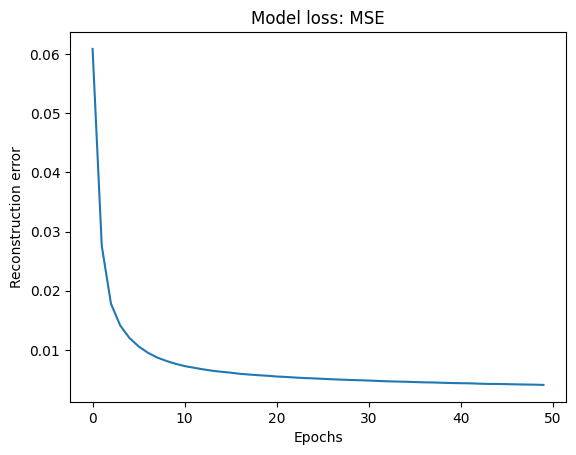

In [18]:
# plot the errors
plt.plot(rbm.errors)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title('Model loss: MSE')
plt.show()

In [19]:
print('Final error:', rbm.errors[-1])

Final error: 0.004095280907992405


## Encoding and Reconstruction 

Let's now visualize the effect of the reconstruction on each digit: I took a random image for each digit from the test set and applied the `reconstruct()` method to them. Comparing the plots of the original (binarized) images with their reconstructed counterparts, we can definitely say that the RBM is able to capture and reconstruct the essential features of the input images. 

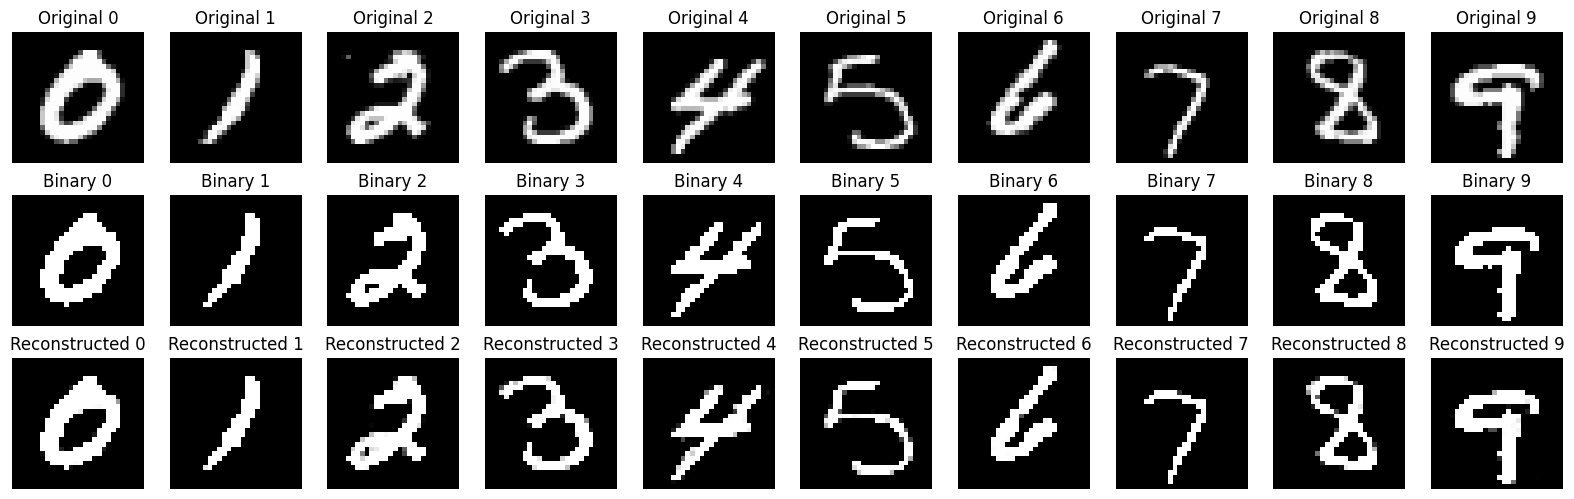

In [43]:
# Take an image from the test set for each digit
digits = []
original_digits = []
for i in range(10):
    index = np.random.randint(0, len(test_images_b[test_labels == i]))
    digits.append(test_images_b[test_labels == i][index])
    original_digits.append(test_images[test_labels == i][index])

# Reconstruct the images
reconstructed_digits = []
for digit in digits:
    reconstructed_digits.append(rbm.reconstruct(digit))

# Plot the original and reconstructed images: first row original, second row binary digits, third row reconstructed
fig, axs = plt.subplots(3, 10, figsize=(20, 6))
for i in range(10):
    axs[0, i].imshow(original_digits[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Original ' + str(i))
    axs[1, i].imshow(digits[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Binary ' + str(i))
    axs[2, i].imshow(reconstructed_digits[i].reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')
    axs[2, i].set_title('Reconstructed ' + str(i))

Let's now see in more precise terms how good the reconstruction we obtain on the test set is. I will use the Structural Similarity Index Measure (SSIM) for the analysis, which is a pretty popular choice for grayscale images.

For each digit, we take the instances in the test set that have that digit as their label and compute the average structural similarity between the original image and its reconstruction. Similarly, we calculate this metric for the binarized test set images.

We can notice that the SSIM scores are higher when computed with respect to the binarized test images, which was predictable given that the RBM was trained on binarized images.

In [21]:
def ssim(rbm, data):
    recon = rbm.reconstruct(data)
    return np.mean([structural_similarity(data[i], recon[i], data_range=1) for i in range(len(data))])

In [47]:
# Flatten the test_images
test_images = test_images.reshape(-1, 28*28)

ssim_scores = []
ssim_scores_b = []

# Compute the SSIM score for each digit in the original test set
for i in range(10):
    ssim_scores.append(ssim(rbm, test_images[test_labels == i]))

# Compute the SSIM score for each digit in the binarized test set
for i in range(10):
    ssim_scores_b.append(ssim(rbm, test_images_b[test_labels == i]))

# Print the ssim scores of each digit
for i in range(10):
    print(f'Digit {i}: SSIM (Original Images) = {ssim_scores[i]}, SSIM (Binarized Images) = {ssim_scores_b[i]}')

Digit 0: SSIM (Original Images) = 0.9176461797395465, SSIM (Binarized Images) = 0.9790685378907672
Digit 1: SSIM (Original Images) = 0.9601661536446402, SSIM (Binarized Images) = 0.998906126223502
Digit 2: SSIM (Original Images) = 0.9109217616059627, SSIM (Binarized Images) = 0.9760908665865216
Digit 3: SSIM (Original Images) = 0.9120024245732385, SSIM (Binarized Images) = 0.981524388792511
Digit 4: SSIM (Original Images) = 0.9278479011633836, SSIM (Binarized Images) = 0.9886151123504064
Digit 5: SSIM (Original Images) = 0.9096052192223315, SSIM (Binarized Images) = 0.9817415883103852
Digit 6: SSIM (Original Images) = 0.9279200691323806, SSIM (Binarized Images) = 0.984939924615408
Digit 7: SSIM (Original Images) = 0.9313667748168765, SSIM (Binarized Images) = 0.9909887783150008
Digit 8: SSIM (Original Images) = 0.9249594560324917, SSIM (Binarized Images) = 0.9814857373375308
Digit 9: SSIM (Original Images) = 0.9334512383334459, SSIM (Binarized Images) = 0.9925070604497551


### Reconstruction of a convex combination of digits
Another interesting visualization to do is to try to reconstruct a convex combination of two different digits and see the effect of changing the coefficients in the combination. It can be noted, in fact, that the reconstruction identifies the dominant digit of the combination, although not perfectly.

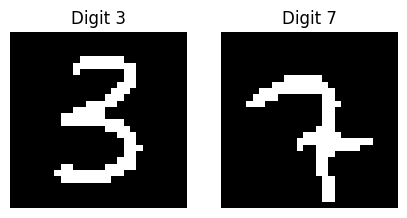

In [129]:
# Take a test image labelled as 3
index = np.random.randint(0, len(test_images_b[test_labels == 3]))
digit_3 = test_images_b[test_labels == 3][index]

# Take a test image labelled as 7
index = np.random.randint(0, len(test_images_b[test_labels == 7]))
digit_7 = test_images_b[test_labels == 7][index]

# Plot the digits on the same row
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(digit_3.reshape(28, 28), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Digit 3')
axs[1].imshow(digit_7.reshape(28, 28), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Digit 7')
plt.show()

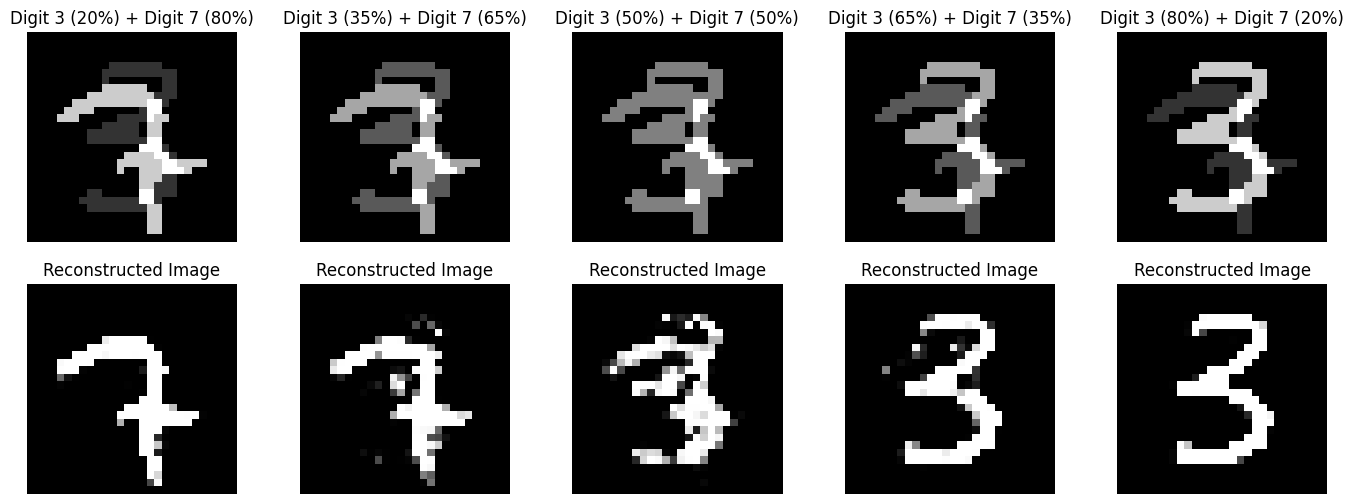

In [137]:
# Take a convex combination of the two images
alpha1 = 0.2
digit_37_1 = alpha1 * digit_3 + (1 - alpha1) * digit_7

# Take another convex combination of the two images
alpha2 = 0.35
digit_37_2 = alpha2 * digit_3 + (1 - alpha2) * digit_7

# Take another convex combination of the two images
alpha3 = 0.5
digit_37_3 = alpha3 * digit_3 + (1 - alpha3) * digit_7

# Take another convex combination of the two images
alpha4 = 0.65
digit_37_4 = alpha4 * digit_3 + (1 - alpha4) * digit_7

# Take another convex combination of the two images
alpha5 = 0.8
digit_37_5 = alpha5 * digit_3 + (1 - alpha5) * digit_7

# Plot the convex combinations on first row and the reconstructed images on the second row
fig, axs = plt.subplots(2, 5, figsize=(17,6))
axs[0, 0].imshow(digit_37_1.reshape(28, 28), cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Digit 3 (20%) + Digit 7 (80%)')
axs[0, 1].imshow(digit_37_2.reshape(28, 28), cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Digit 3 (35%) + Digit 7 (65%)')
axs[0, 2].imshow(digit_37_3.reshape(28, 28), cmap='gray')
axs[0, 2].axis('off')
axs[0, 2].set_title('Digit 3 (50%) + Digit 7 (50%)')
axs[0, 3].imshow(digit_37_4.reshape(28, 28), cmap='gray')
axs[0, 3].axis('off')
axs[0, 3].set_title('Digit 3 (65%) + Digit 7 (35%)')
axs[0, 4].imshow(digit_37_5.reshape(28, 28), cmap='gray')
axs[0, 4].axis('off')
axs[0, 4].set_title('Digit 3 (80%) + Digit 7 (20%)')
axs[1, 0].imshow(rbm.reconstruct(digit_37_1).reshape(28, 28), cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Reconstructed Image')
axs[1, 1].imshow(rbm.reconstruct(digit_37_2).reshape(28, 28), cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Reconstructed Image')
axs[1, 2].imshow(rbm.reconstruct(digit_37_3).reshape(28, 28), cmap='gray')
axs[1, 2].axis('off')
axs[1, 2].set_title('Reconstructed Image')
axs[1, 3].imshow(rbm.reconstruct(digit_37_4).reshape(28, 28), cmap='gray')
axs[1, 3].axis('off')
axs[1, 3].set_title('Reconstructed Image')
axs[1, 4].imshow(rbm.reconstruct(digit_37_5).reshape(28, 28), cmap='gray')
axs[1, 4].axis('off')
axs[1, 4].set_title('Reconstructed Image')
plt.show()

Let's see if there is some relevant change if we do the reconstruction of the convex combination of the encodings, rather than working directly with the encoding of the convex combination of digits as we did in the cells above. 

In the cell below, in fact, I considered the encodings of the two digits, and then I reconstructed the convex combinations of the encodings (for the same coefficients as before: 0.2, 0.35, 0.5, 0.65, 0.8). We can see that for the 50/50 case there are many fewer pixels on compared to the previous reconstruction. Moreover, the transition is "more clean" in this second version: in the 35/65 and 65/35 cases the white pixels were in correspondence of the dominant digit, while in the reconstructions above there was more noise.

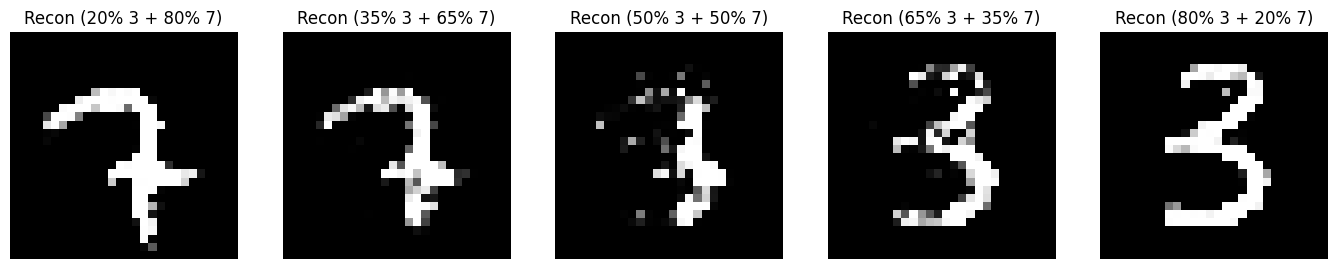

In [141]:
# Encoding of Digit 3
hidden_prob_3 = rbm.encoding(digit_3)

# Encoding of Digit 7
hidden_prob_7 = rbm.encoding(digit_7)

# Reconstruct the convex combination of the two encodings using alpha1
alpha1_encoding = alpha1 * hidden_prob_3 + (1 - alpha1) * hidden_prob_7
alpha1_recon = 1 / (1 + np.exp(-np.dot(alpha1_encoding, rbm.W) - rbm.bv))

# Reconstruct the convex combination of the two encodings using alpha2
alpha2_encoding = alpha2 * hidden_prob_3 + (1 - alpha2) * hidden_prob_7
alpha2_recon = 1 / (1 + np.exp(-np.dot(alpha2_encoding, rbm.W) - rbm.bv))

# Reconstruct the convex combination of the two encodings using alpha3
alpha3_encoding = alpha3 * hidden_prob_3 + (1 - alpha3) * hidden_prob_7
alpha3_recon = 1 / (1 + np.exp(-np.dot(alpha3_encoding, rbm.W) - rbm.bv))

# Reconstruct the convex combination of the two encodings using alpha4
alpha4_encoding = alpha4 * hidden_prob_3 + (1 - alpha4) * hidden_prob_7
alpha4_recon = 1 / (1 + np.exp(-np.dot(alpha4_encoding, rbm.W) - rbm.bv))

# Reconstruct the convex combination of the two encodings using alpha5
alpha5_encoding = alpha5 * hidden_prob_3 + (1 - alpha5) * hidden_prob_7
alpha5_recon = 1 / (1 + np.exp(-np.dot(alpha5_encoding, rbm.W) - rbm.bv))

# Plot the reconstructions on the same row
fig, axs = plt.subplots(1, 5, figsize=(17, 5))
axs[0].imshow(alpha1_recon.reshape(28, 28), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Recon (20% 3 + 80% 7)')
axs[1].imshow(alpha2_recon.reshape(28, 28), cmap='gray')
axs[1].axis('off')
axs[1].set_title('Recon (35% 3 + 65% 7)')
axs[2].imshow(alpha3_recon.reshape(28, 28), cmap='gray')
axs[2].axis('off')
axs[2].set_title('Recon (50% 3 + 50% 7)')
axs[3].imshow(alpha4_recon.reshape(28, 28), cmap='gray')
axs[3].axis('off')
axs[3].set_title('Recon (65% 3 + 35% 7)')
axs[4].imshow(alpha5_recon.reshape(28, 28), cmap='gray')
axs[4].axis('off')
axs[4].set_title('Recon (80% 3 + 20% 7)')
plt.show()

## Classification Phase

Let's start by identifying a MLP model that gives satisfying results on the MNIST dataset: a single layer with 512 units works pretty well.

Accuracy: 0.9698


/Users/irene/VSCodeProjects/ISPR/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


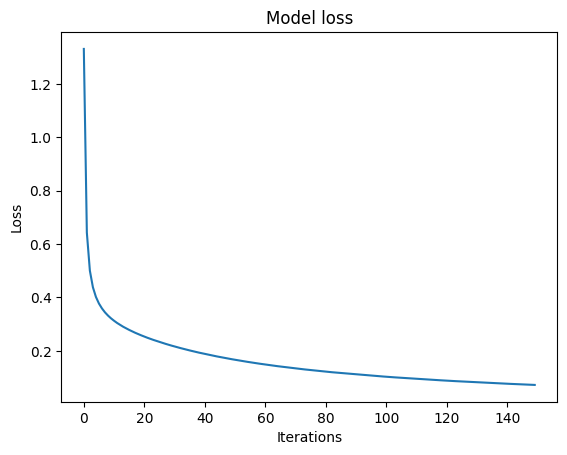

In [23]:
model = MLPClassifier(
    hidden_layer_sizes=(512,), 
    max_iter=150, 
    alpha=1e-4,
    solver='sgd'
)
model.fit(train_images_b, train_labels)

predictions = model.predict(test_images_b)
accuracy = accuracy_score(test_labels, predictions)

print('Accuracy:', accuracy)

# Plot the loss
plt.plot(model.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

In [24]:
print('Classification report: \n', classification_report(test_labels, predictions))

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



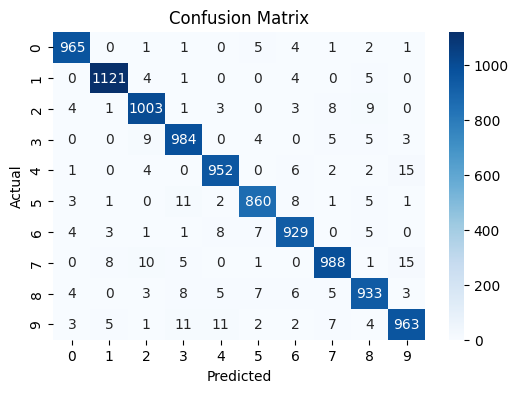

In [25]:
# Plot the confusion matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Now, let's prepare the econdings relative to the train and test sets using the method `encoding()` of the class `RBM` implemented above in the notebook; then, I will train the same MLP model as before (1 hidden layer of 512 units) on the encoded train set, and test it on the encoded test set.

In [26]:
train_images_encodings = rbm.encoding(train_images_b)
test_images_encodings = rbm.encoding(test_images_b)

Accuracy: 0.964


/Users/irene/VSCodeProjects/ISPR/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


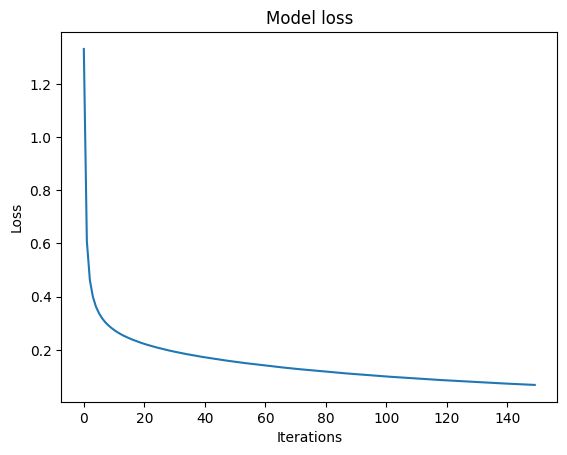

In [27]:
model.fit(train_images_encodings, train_labels)

predictions = model.predict(test_images_encodings)
accuracy = accuracy_score(test_labels, predictions)

print('Accuracy:', accuracy)

# Plot the loss
plt.plot(model.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

In [28]:
print('Classification report: \n', classification_report(test_labels, predictions))

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.96      0.95      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



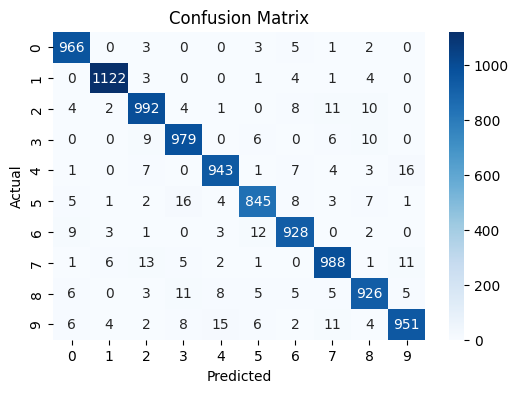

In [29]:
# Plot the confusion matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Personal Considerations

With this task I was able to delve deeper into the implementation details of Restricted Boltzamann Machines, also noting their effectiveness and seeing how they can be exploited to reduce the size of a problem. 

In fact, what I did in the last section 'Classification Phase' was precisely to reduce the dimensionality of the images of the MNIST dataset; training on the encodings let us to switch from a model of $\textcolor{magenta}{784}*512 + 512*10 = 406.528$ weights, to a size of: $\textcolor{magenta}{512}*512 + 512*10 = 267.264$. This is because in the "traditional" version the inputs are the MNIST images that have a length of 784, while in the version with encodings the inputs are as long as the number of hidden units, which for the chosen RBM are 512.

This reduction in complexity did not led to a significant worsening of performances: accuracy dropped from 0.9698 to 0.964, and the worsening of the metrics (precision, recall, f1-score) occurred rather homogeneously for the various classes, and was not excessive.

With a more accurate grid search on the RBM perhaps I could have found an RBM with even fewer hidden units that had good performances, and at that point the advantage would have been even greater because the complexity would have been further reduced.

Finally, improvements could be made from an implementation point of view. Regarding the training algorithm, one could realize CD-k by taking multiple steps to approximate the positive and negative phases of contrastive divergence, and thus be able to capture more of the underlying distribution of the data, leading to more accurate parameter updates. To tackle the phenomenon of overfitting, techniques such as weight decay or dropout can be used; the choice of learning rate can be refined too, for example by looking at the weight updates and implementing learning rate schedules. Parallelizing the code would also make everything faster.